In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def plot_topic_presence(df, num_topics, min_year=None, max_year=None, save=False):
    g = pd.merge(
        df.groupby(["year", f"word_label_{num_topics}"], as_index=False).size(),
        df.groupby("year", as_index=False).size(),
        how="left",
        on="year",
        suffixes=("_per_topic", "_per_year")
    )
    g["pct"] = (g["size_per_topic"] / g["size_per_year"] * 100).round(2)
    g = g.rename(columns={f"word_label_{num_topics}": "labels"})
    
    if min_year is not None and max_year is not None:
        g = g.query(f"{min_year} <= `year` <= {max_year}")
    if max_year is not None and min_year is None:
        g = g.query(f"`year` <= {max_year}")
    if min_year is not None and max_year is None:
        g = g.query(f"`year` >= {min_year}")
    
    fig, ax = plt.subplots(1, 1, figsize=(18,9))
    for topic in g["labels"].unique():
        data = g.loc[g["labels"].eq(topic)]
        ax.plot("year", "pct", data=data, label=topic)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(bottom=False, left=False)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.set(
        xlabel="Date", 
        ylabel="Average Yearly Topic Weight",
    )
    plt.xticks(g["year"].unique())
    plt.legend(loc='upper right')
    fig.suptitle(f"ProQuest Corpus Topic Presence ({g['year'].min()} - {g['year'].max()})", fontsize=20, fontweight='bold',x=0.125,ha='left')
    if save:
        plt.savefig("../reports/figures/2.0-mpl-diachronic.png", dpi=300, bbox_inches="tight", pad_inches=0.3, transparent=False)

In [3]:
dataset = pd.read_json("../data/raw/210119_en_deter_preprocessed.json")
dataset = dataset.loc[~dataset["fulltext"].str.contains("Not available.")].copy()
embeddings = pd.read_csv("../data/processed/deciding-on-topic-reduction.csv")

In [4]:
assert dataset.shape[0] == embeddings.shape[0]

redundant_cols = ["doc_id", "link", "onestring", "threshold", "pub_title", "lang"]
df = pd.merge(
    dataset.drop(redundant_cols, axis=1),
    embeddings,
    how="left",
    left_index=True,
    right_index=True
)

In [5]:
df = df.loc[df["date"].notnull()].copy()
df["year"] = pd.to_datetime(df["date"]).dt.year.astype(int)

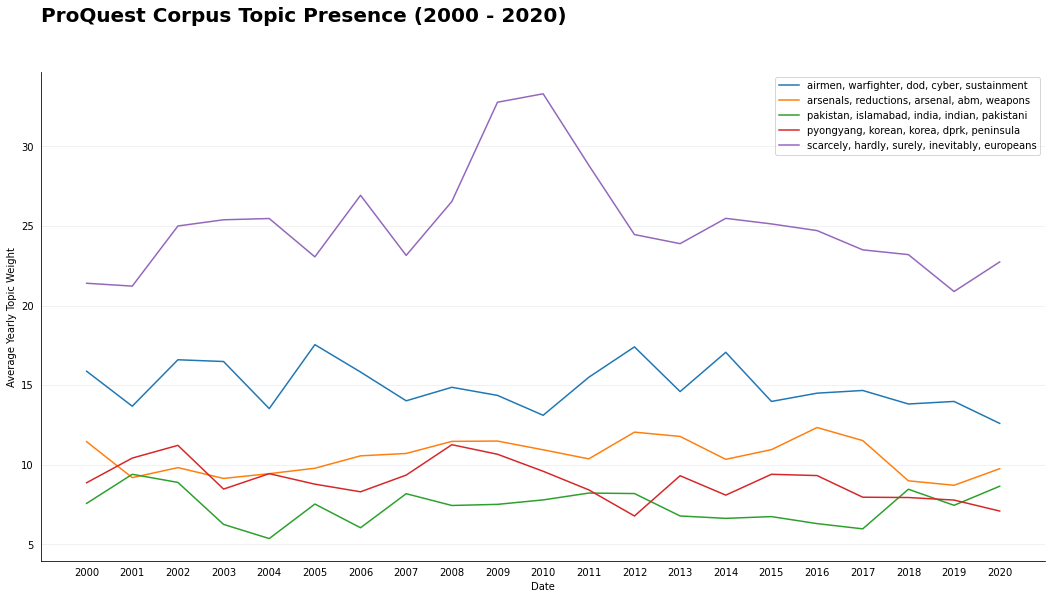

In [6]:
plot_topic_presence(df, num_topics=5, min_year=2000, max_year=2020)